In [1]:
import numpy as np
import pandas as pd
import time

In [2]:
from sklearn.neighbors import BallTree

In [3]:
import matplotlib.pyplot as plt
import matplotlib as cm

In [4]:
X_train = np.load('X_train_surge.npz')
Y_train = pd.read_csv('Y_train_surge.csv')

Now I practice on how to deal with the npz format. The npz format stores archives in a dictionary. Bellow the keywords for the dictionary in X_train
*  id_sequence: the ids of the sequence
*  t_slp: the 40 GMT times at which the sea-level pressure (SLP) fields are given.\\
*  slp: the 40 sea-level pressure (SLP) fields, encoded in images of size (41, 41).\\
*  t_surge1_input: the 10 GMT times at which the surge heights are given in city 1.\\
*  surge1_input: the given surge heights in city 1.\\
*  t_surge2_input: the 10 GMT times at which the surge heights are given in city 2.\\
*  surge2_input: the given surge heights in city 2.\\
*  t_surge1_output: the 10 GMT times at which we must predict surge heights in city 1.\\
* t_surge2_output: the 10 GMT times at which we must predict surge heights in city 2.\\


In [5]:
id_seq=X_train['id_sequence']
t_slp=X_train['t_slp']
slp=X_train['slp']
t_surge1_input=X_train['t_surge1_input']
surge1_input=X_train['surge1_input']
t_surge2_input=X_train['t_surge2_input']
surge2_input=X_train['surge2_input']
t_surge1_output=X_train['t_surge1_output']
t_surge2_output=X_train['t_surge2_output']

In [6]:
t_slp.shape

(5599, 40)

In [7]:
t_slp[1]

array([-6.309792e+08, -6.309684e+08, -6.309576e+08, -6.309468e+08,
       -6.309360e+08, -6.309252e+08, -6.309144e+08, -6.309036e+08,
       -6.308928e+08, -6.308820e+08, -6.308712e+08, -6.308604e+08,
       -6.308496e+08, -6.308388e+08, -6.308280e+08, -6.308172e+08,
       -6.308064e+08, -6.307956e+08, -6.307848e+08, -6.307740e+08,
       -6.307632e+08, -6.307524e+08, -6.307416e+08, -6.307308e+08,
       -6.307200e+08, -6.307092e+08, -6.306984e+08, -6.306876e+08,
       -6.306768e+08, -6.306660e+08, -6.306552e+08, -6.306444e+08,
       -6.306336e+08, -6.306228e+08, -6.306120e+08, -6.306012e+08,
       -6.305904e+08, -6.305796e+08, -6.305688e+08, -6.305580e+08],
      dtype=float32)

In [8]:
time.gmtime(t_slp[1,1])

/tmp/ipykernel_21321/2935827488.py:1: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  time.gmtime(t_slp[1,1])


time.struct_time(tm_year=1950, tm_mon=1, tm_mday=3, tm_hour=3, tm_min=0, tm_sec=16, tm_wday=1, tm_yday=3, tm_isdst=0)

To have an idea of the time elapsed more clearly will convert every time series to hours and take the difference with respect to the first time in each sequence, this way all the series will be in the same terms. 

In [9]:
def to_hours_deltas(seq):
    aux=seq-np.roll(seq,1)
    aux[0]=0
    return np.cumsum(aux)/3600

In [10]:
t_slp_hours_delta=np.zeros(t_slp.shape)
for i in range(len(t_slp)):
    t_slp_hours_delta[i]=to_hours_deltas(t_slp[i])

In [11]:
t_slp_hours_delta[10]

array([  0.        ,   2.98666668,   5.99111128,   8.99555588,
        11.98222256,  14.98666668,  17.99111176,  20.99555588,
        24.        ,  26.98666573,  29.99111176,  32.99555588,
        35.98222351,  38.98666763,  41.99111176,  44.99555588,
        48.        ,  50.98666763,  53.99111176,  56.99555588,
        59.98222351,  62.98666763,  65.99111176,  68.99555206,
        72.        ,  74.98666382,  77.99111176,  80.99555206,
        83.98222351,  86.98666382,  89.99111176,  92.99555206,
        96.        ,  98.98666382, 101.99111176, 104.99555206,
       107.98222351, 110.98666382, 113.99111176, 116.99555206])

In [12]:
(t_surge1_input[10]-t_slp[10,0])/3600

array([-11.004444 ,   1.9911112,  13.991111 ,  25.991112 ,  38.986668 ,
        51.982224 ,  64.       ,  76.99555  ,  89.99111  , 101.99111  ],
      dtype=float32)

In [13]:
t_slp_hours_delta[10]

array([  0.        ,   2.98666668,   5.99111128,   8.99555588,
        11.98222256,  14.98666668,  17.99111176,  20.99555588,
        24.        ,  26.98666573,  29.99111176,  32.99555588,
        35.98222351,  38.98666763,  41.99111176,  44.99555588,
        48.        ,  50.98666763,  53.99111176,  56.99555588,
        59.98222351,  62.98666763,  65.99111176,  68.99555206,
        72.        ,  74.98666382,  77.99111176,  80.99555206,
        83.98222351,  86.98666382,  89.99111176,  92.99555206,
        96.        ,  98.98666382, 101.99111176, 104.99555206,
       107.98222351, 110.98666382, 113.99111176, 116.99555206])

Now, the series of times at which the surges are measured will be given wrt the time at which measurements of the slp started

In [14]:
t_surge1_input_hours=np.zeros(t_surge1_input.shape)
for i in range(len(t_surge1_input)):
    t_surge1_input_hours[i]=(t_surge1_input[i]-t_slp[i,0])/3600
t_surge2_input_hours=np.zeros(t_surge2_input.shape)
for i in range(len(t_surge2_input)):
    t_surge2_input_hours[i]=(t_surge2_input[i]-t_slp[i,0])/3600

       

Now do the same thing for the output times

In [15]:
t_surge1_output_hours=np.zeros(t_surge1_output.shape)
for i in range(len(t_surge1_output)):
    t_surge1_output_hours[i]=(t_surge1_output[i]-t_slp[i,0])/3600
t_surge2_output_hours=np.zeros(t_surge2_output.shape)
for i in range(len(t_surge2_output)):
    t_surge2_output_hours[i]=(t_surge2_output[i]-t_slp[i,0])/3600



Let's play a bit with the slp maps 

Bellow we can observe that the slp maps they provide are actually rolled so that they at the begining look a bit strange. In the next cell I correct this, by rolling the whole map by 10 steps along the x axis, this way it looks wayy better. 

In [24]:
slp_corrected=np.zeros(slp.shape)
for i in range(len(slp)):
    for j in range(len(slp[i])):
        slp_corrected[i,j]=np.roll(slp[i,j],-11,axis=1)


In [25]:
slp[1,1]-slp[1,0]

array([[-35.273438 , -40.273438 , -45.273438 , ..., -25.273438 ,
        -26.273438 , -30.273438 ],
       [-29.273438 , -33.273438 , -38.273438 , ..., -29.273438 ,
        -27.273438 , -27.273438 ],
       [-28.273438 , -31.273438 , -34.273438 , ..., -32.273438 ,
        -30.273438 , -27.273438 ],
       ...,
       [ 38.726562 ,  50.726562 ,  64.72656  , ...,   8.7265625,
         18.726562 ,  27.726562 ],
       [ 49.726562 ,  59.726562 ,  69.72656  , ...,  19.726562 ,
         28.726562 ,  38.726562 ],
       [ 46.726562 ,  54.726562 ,  59.726562 , ...,  22.726562 ,
         31.726562 ,  40.726562 ]], dtype=float32)

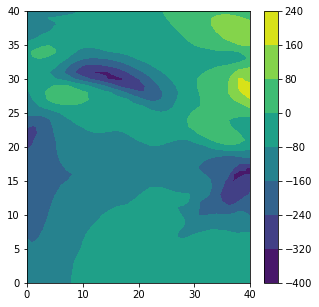

In [26]:
deltaslp=slp_corrected[1,1]-slp_corrected[1,0]
plt.figure(figsize=(5,5))
norm = cm.colors.Normalize(vmax=abs(deltaslp).max(), vmin=-abs(deltaslp).max())
plt.contourf(deltaslp)
plt.colorbar()
plt.show()

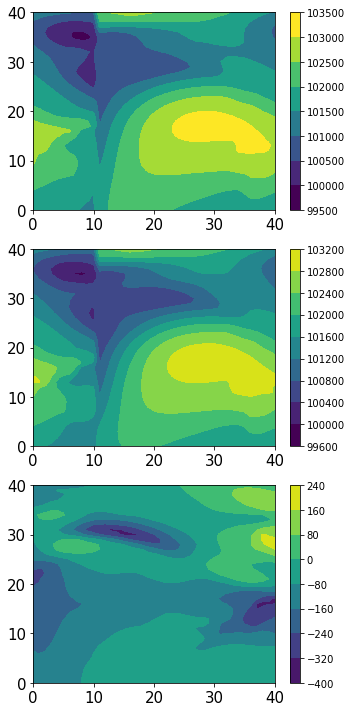

In [20]:
fig, _axs = plt.subplots(nrows=3, ncols=1,figsize=(5, 10))
fig.subplots_adjust(hspace=0.4)
axs = _axs.flatten()
norm0=cm.colors.Normalize(vmax=slp[1,0].max(), vmin=slp[1,0].min())
mapt = axs[0].contourf(slp[1,0],norm=norm0)
fig.colorbar(mapt,ax=axs[0])
mapt1 =axs[1].contourf(slp[1,1],norm=norm0)
fig.colorbar(mapt1,ax=axs[1])
deltamap=axs[2].contourf(deltaslp)
fig.colorbar(deltamap,ax=axs[2])
for i in range(len(axs)):
    axs[i].tick_params(labelsize='15')
fig.tight_layout()
plt.show()

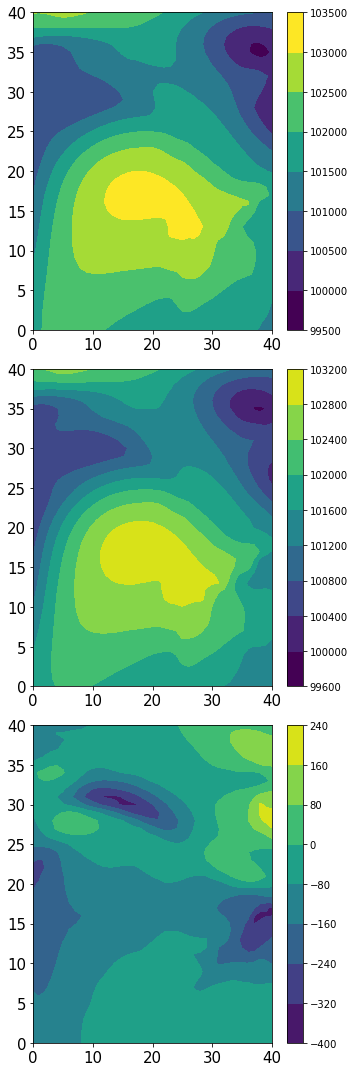

In [118]:
fig, _axs = plt.subplots(nrows=3, ncols=1,figsize=(5, 15))
fig.subplots_adjust(hspace=0.4)
axs = _axs.flatten()
norm0=cm.colors.Normalize(vmax=slp[1,0].max(), vmin=slp_corrected[1,0].min())
mapt = axs[0].contourf(slp_corrected[1,0],norm=norm0)
fig.colorbar(mapt,ax=axs[0])
mapt1 =axs[1].contourf(slp_corrected[1,1],norm=norm0)
fig.colorbar(mapt1,ax=axs[1])
deltamap=axs[2].contourf(slp_corrected[1,1]-slp_corrected[1,0])
fig.colorbar(deltamap,ax=axs[2])
for i in range(len(axs)):
    axs[i].tick_params(labelsize='15')
fig.tight_layout()
plt.show()

In [ ]:
norm2=cm.colors.Normalize(vmax=np.max(slp_corrected), vmin=np.min(slp_corrected))

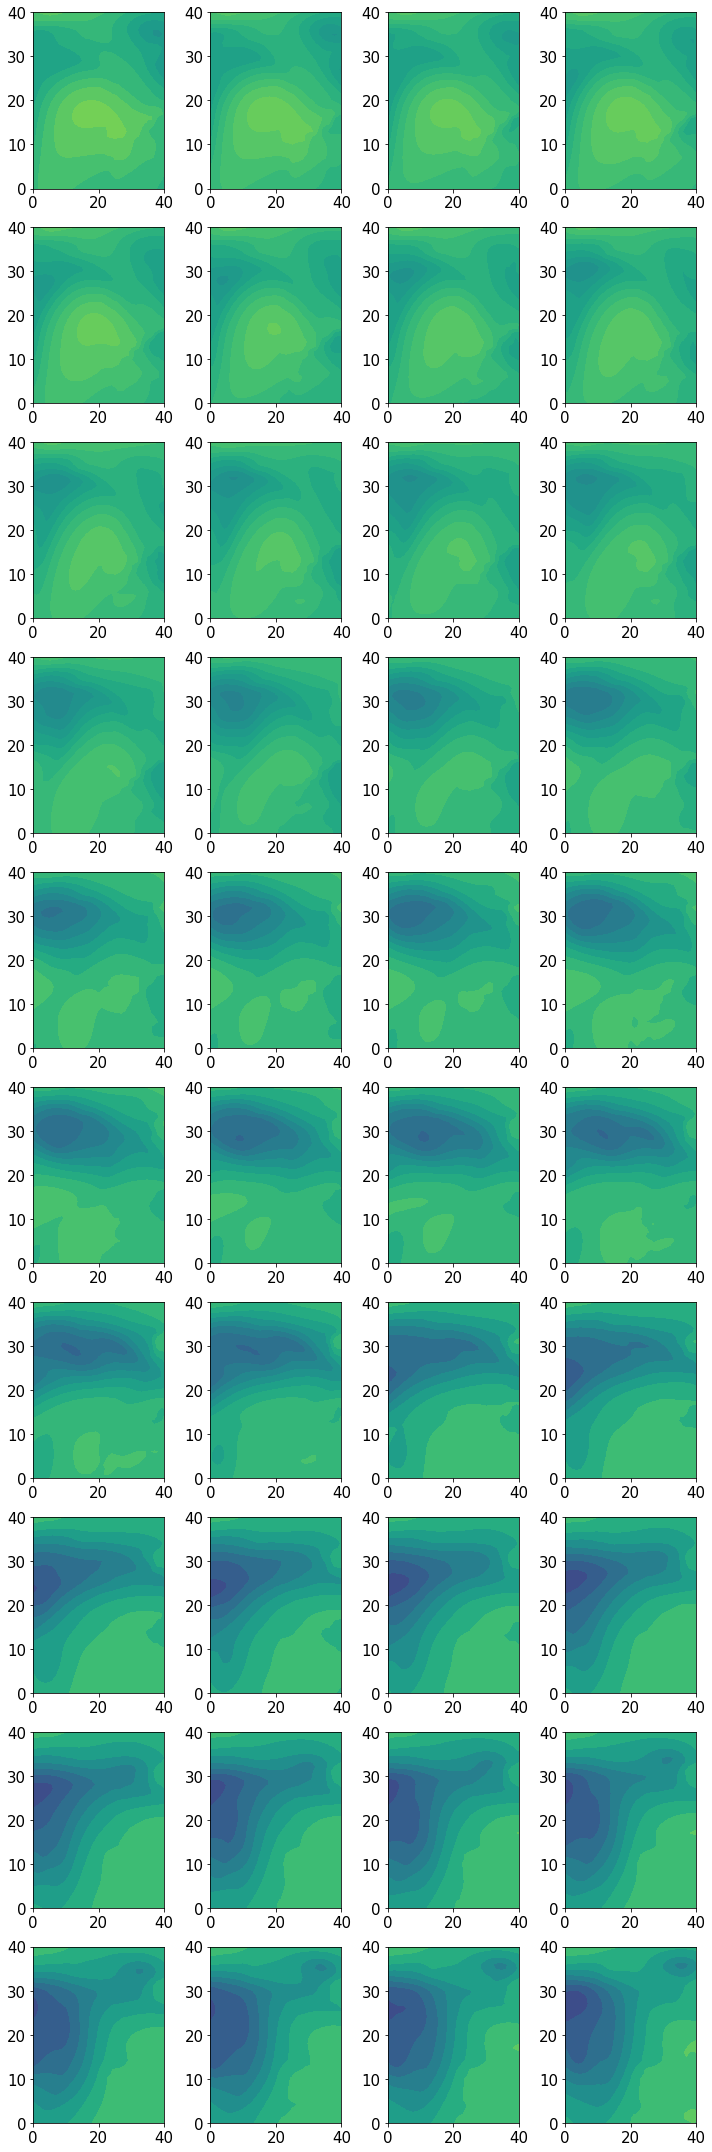

In [182]:
fig, _axs = plt.subplots(nrows=10, ncols=4,figsize=(10, 30))
fig.subplots_adjust(hspace=0.4)
axs = _axs.flatten()
for i in range(len(axs)):
    mpt[i]=axs[i].contourf(np.roll(slp[1,i],-11,axis=1),norm=norm2)
    axs[i].tick_params(labelsize='15')
fig.tight_layout()
plt.show()

In [128]:
deltaslps=np.zeros((slp.shape[0],slp.shape[1]-1,slp.shape[2],slp.shape[3]))
for i in range(len(deltaslps)):
    for j in range(len(deltaslps[i])):
        deltaslps[i,j]=slp_corrected[i,j+1]-slp_corrected[i,j]



In [139]:
limits_for_norm=np.zeros((len(deltaslps),2))
for i in range(len(deltaslps)):
    limits_for_norm[i,0]=np.min(deltaslps[i])
    limits_for_norm[i,1]=np.max(deltaslps[i])

In [137]:
np.max(deltaslps[0])

348.9375

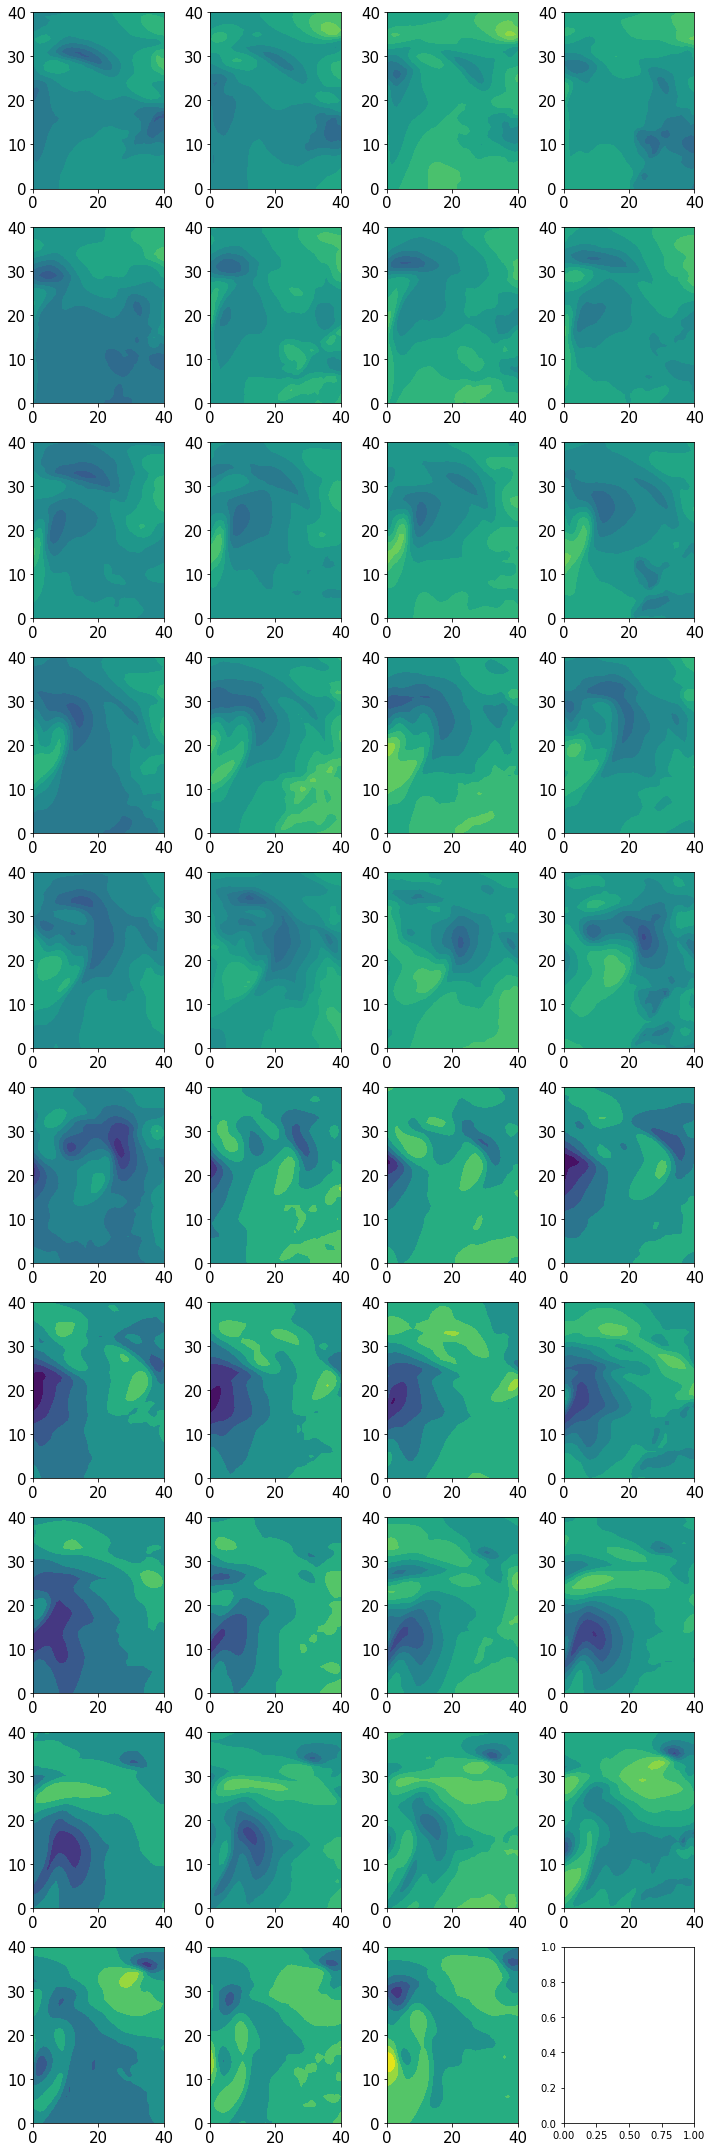

In [185]:


fig, _axs = plt.subplots(nrows=10, ncols=4,figsize=(10, 30))
fig.subplots_adjust(hspace=0.4)
axs = _axs.flatten()
norm1=cm.colors.Normalize(vmax=limits_for_norm[1,1], vmin=limits_for_norm[1,0])
for i in range (1,len(axs)):
    axs[i-1].contourf((np.roll(slp[1,i],-11,axis=1))-(np.roll(slp[1,i-1],-11,axis=1)),norm=norm1)
    axs[i-1].tick_params(labelsize='15')
fig.tight_layout()
plt.show()

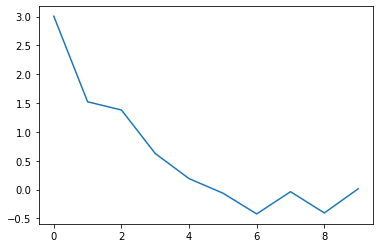

In [163]:
plt.plot(surge2_input[15])

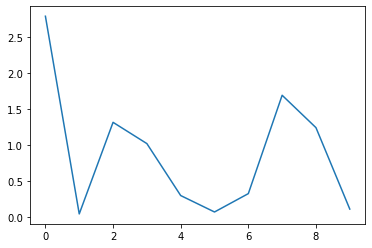

In [162]:
plt.plot(surge1_input[15])

Now I will have a look at the output file Y_train

In [177]:
Y_train

,id_sequence,surge1_t0,surge1_t1,surge1_t2,surge1_t3,surge1_t4,surge1_t5,surge1_t6,surge1_t7,surge1_t8,...,surge2_t0,surge2_t1,surge2_t2,surge2_t3,surge2_t4,surge2_t5,surge2_t6,surge2_t7,surge2_t8,surge2_t9
0,1,0.586936,1.069580,0.767928,-0.100162,0.070775,-0.244285,-0.354891,-0.928031,-0.773853,...,-0.053886,0.356847,0.348464,0.264641,0.901696,0.449052,0.113760,-0.422707,-0.456236,-0.825057
1,2,0.767928,-0.100162,0.070775,-0.244285,-0.354891,-0.928031,-0.773853,-0.375001,-0.361594,...,0.348464,0.264641,0.901696,0.449052,0.113760,-0.422707,-0.456236,-0.825057,-0.992703,-0.992703
2,3,0.070775,-0.244285,-0.354891,-0.928031,-0.773853,-0.375001,-0.361594,-0.210768,0.288635,...,0.901696,0.449052,0.113760,-0.422707,-0.456236,-0.825057,-0.992703,-0.992703,-0.322119,-0.883733
3,4,-0.354891,-0.928031,-0.773853,-0.375001,-0.361594,-0.210768,0.288635,-0.726929,-0.576103,...,0.113760,-0.422707,-0.456236,-0.825057,-0.992703,-0.992703,-0.322119,-0.883733,-0.473001,-0.422707
4,5,-0.773853,-0.375001,-0.361594,-0.210768,0.288635,-0.726929,-0.576103,1.160076,0.442813,...,-0.456236,-0.825057,-0.992703,-0.992703,-0.322119,-0.883733,-0.473001,-0.422707,-0.473001,-0.531677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5594,5595,1.451674,1.220407,0.556771,1.709754,0.483033,0.533309,1.448322,1.820360,1.662831,...,0.759197,0.884931,0.298171,-0.397560,-0.540059,-0.498148,-0.498148,-0.405942,0.164054,0.331700
5595,5596,0.556771,1.709754,0.483033,0.533309,1.448322,1.820360,1.662831,1.528763,1.284089,...,0.298171,-0.397560,-0.540059,-0.498148,-0.498148,-0.405942,0.164054,0.331700,1.052577,1.220223
5596,5597,0.483033,0.533309,1.448322,1.820360,1.662831,1.528763,1.284089,0.070775,0.888589,...,-0.540059,-0.498148,-0.498148,-0.405942,0.164054,0.331700,1.052577,1.220223,1.446545,2.670360
5597,5598,1.448322,1.820360,1.662831,1.528763,1.284089,0.070775,0.888589,1.545521,1.166779,...,-0.498148,-0.405942,0.164054,0.331700,1.052577,1.220223,1.446545,2.670360,2.620066,2.678742


In [173]:
surge_train=np.array(Y_train)[:,1:] #surge_train[0:9] -> surge1
                                    #surge_train[10:19] -> surge2

In [175]:
surge_train.shape

(5599, 20)

In [178]:
surge_train[0]

array([ 0.58693592,  1.06958024,  0.76792754, -0.1001619 ,  0.07077463,
       -0.24428486, -0.35489084, -0.92803097, -0.77385293, -0.37500102,
       -0.05388589,  0.35684658,  0.34846428,  0.26464133,  0.90169576,
        0.44905182,  0.11376001, -0.42270688, -0.45623606, -0.82505705])

In [190]:
case1=np.concatenate((surge1_input[10],surge_train[10,0:9]))
case2=np.concatenate((surge2_input[10],surge_train[10,10:19]))

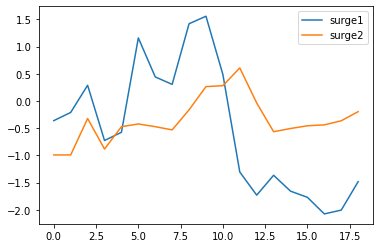

In [191]:
plt.plot(case1,label='surge1')
plt.plot(case2,label='surge2')
plt.legend()
plt.show()

As a try I will do the BallTree thing but with the gradients of the slp fields. I think it should be more subtle than that though. 

In [205]:
nfields = 4; time_step_slp = 4
deltaslp_train = []
for i in range(len(deltaslps)):
    deltaslp_train.append(np.ndarray.flatten(deltaslps[i,-1]))
    for j in range(1,nfields):
        deltaslp_train[-1] = np.concatenate( ( deltaslp_train[-1], np.ndarray.flatten(deltaslps[i,-1-j*time_step_slp]) ) )
deltaslp_train = np.array(deltaslp_train)

In [206]:
tree = BallTree(deltaslp_train)

In [235]:
surge_train_benchmark_deltas = []; k = 40
for i in range(5559):
    dist, ind = tree.query([deltaslp_train[i]], k=k)
    surge_train_benchmark_deltas.append(np.mean(surge_train[ind[0]], axis=0))
surge_train_benchmark_deltas = np.array(surge_train_benchmark_deltas)

In [236]:
surge_train_benchmark_deltas.shape

(5559, 20)

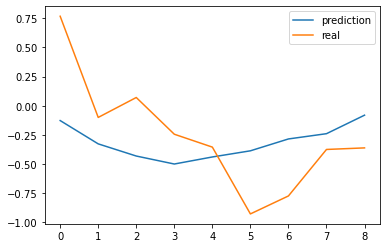

In [237]:
plt.plot(surge_train_benchmark_deltas[1,0:9],label='prediction')
plt.plot(surge_train[1,0:9],label='real')
plt.legend()
plt.show()



Let's check the benchmark to see if they are really different the results

In [220]:
nfields = 2; time_step_slp = 8
slp_train = []
for i in range(5559):
    slp_train.append(np.ndarray.flatten(slp[i,-1]))
    for j in range(1,nfields):
        slp_train[-1] = np.concatenate( ( slp_train[-1], np.ndarray.flatten(slp[i,-1-j*time_step_slp]) ) )
slp_train = np.array(slp_train)

In [221]:
tree2 = BallTree(slp_train)

In [225]:
slp.shape

(5599, 40, 41, 41)

In [229]:
surge_train_benchmark = []; k = 40
for i in range(5559):
    dist, ind = tree2.query([slp_train[i]], k=k)
    surge_train_benchmark.append(np.mean(surge_train[ind[0]], axis=0))
surge_train_benchmark = np.array(surge_train_benchmark)

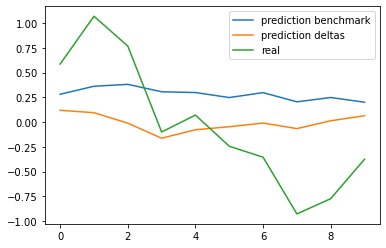

In [273]:
plt.plot(surge_train_benchmark[0,0:10],label='prediction benchmark')
plt.plot(surge_train_benchmark_deltas[0,0:10],label='prediction deltas')
plt.plot(surge_train[0,0:10],label='real')
plt.legend()
plt.show()

Now I will consider the variation profiles following each process, and then use again the k-tree and sum with respect to the sequence. I.e 
* Take all the lists of outputs and create a list of delta_{t\rightarrow t+1}, starting from the last step of the input sequence
* Do the same as in the benchmark, i.e find the closest "neighbors" of the given sequence of slp's. 
* Average the variations corresponding to those neighbors and create the corresponding new sequence. 

In [269]:
#create the list of variations 
delta_surge_train=np.zeros(surge_train.shape)
for i in range(len(delta_surge_train)):
    delta_surge_train[i,0:10]=surge_train[i,0:10]-surge1_input[i,-1]
    delta_surge_train[i,10:20]=surge_train[i,10:20]-surge2_input[i,-1]    

In [271]:
delta_surge_train[0]

array([ 2.29926387,  2.78190819,  2.48025549,  1.61216606,  1.78310259,
        1.4680431 ,  1.35743711,  0.78429698,  0.93847503,  1.33732693,
        0.31852721,  0.72925967,  0.72087738,  0.63705443,  1.27410886,
        0.82146492,  0.48617311, -0.05029378, -0.08382296, -0.45264395])

In [280]:
surge_train[0,0:10]


array([ 0.58693592,  1.06958024,  0.76792754, -0.1001619 ,  0.07077463,
       -0.24428486, -0.35489084, -0.92803097, -0.77385293, -0.37500102])

In [281]:
surge2_input[0,-1]

-0.3724131

In [272]:
surge_train[0,0:10]-surge1_input[0,-1]

array([2.29926387, 2.78190819, 2.48025549, 1.61216606, 1.78310259,
       1.4680431 , 1.35743711, 0.78429698, 0.93847503, 1.33732693])

In [282]:
dsurge_train_benchmark = []; k = 40
for i in range(5559):
    dist, ind = tree2.query([slp_train[i]], k=k)
    dsurge_train_benchmark.append(np.mean(delta_surge_train[ind[0]], axis=0))
dsurge_train_benchmark = np.array(dsurge_train_benchmark)

In [288]:
dsurge_train_benchmark[0,0:10]+surge1_input[0,-1]

array([-1.47821195, -1.39760364, -1.37841518, -1.4533256 , -1.4611183 ,
       -1.51164512, -1.46187243, -1.55504959, -1.51130995, -1.55890405])

In [294]:
surge_train_benchmark_from_seq_var=np.zeros(dsurge_train_benchmark.shape)
for i in range(len(surge_train_benchmark_from_seq_var)):
    surge_train_benchmark_from_seq_var[i,0:10]=surge1_input[i,-1]+dsurge_train_benchmark[i,0:10]
    surge_train_benchmark_from_seq_var[i,10:20]=surge2_input[i,-1]+dsurge_train_benchmark[i,10:20]

In [293]:
surge_train_benchmark_from_seq_var.shape

(5559, 20)

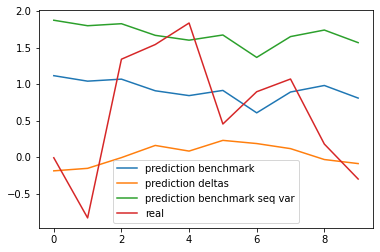

In [298]:
plt.plot(surge_train_benchmark[100,0:10],label='prediction benchmark')
plt.plot(surge_train_benchmark_deltas[100,0:10],label='prediction deltas')
plt.plot(surge_train_benchmark_from_seq_var[100,0:10],label='prediction benchmark seq var')
plt.plot(surge_train[100,0:10],label='real')
plt.legend()
plt.show()

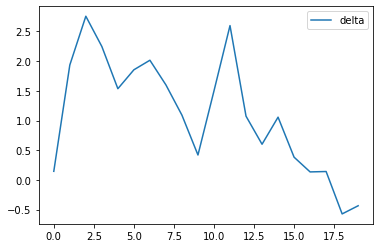

In [311]:
plt.plot(np.concatenate((surge1_input[20],surge_train[20,0:10])),label='delta')
plt.legend()
plt.show()

I want to try to do now this: compute the covariance between the slp at time t-k with the surge at time t at both of the points of analysis. 
First, I will just pick up a point, say (20,20) of the map and consider the correlation of this value with the value at shore 1 at the first moment of time of the output. 


In [317]:
covariances=np.zeros(len(slp[0]))
for i in range(len(covariances)):
    covariances[i]=np.cov(surge_train[:,0],slp[:,i,20,20])[0,1]

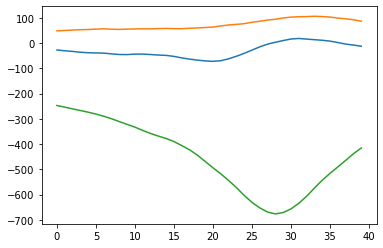

In [324]:
plt.plot(covariances)
plt.plot(covariances2)
plt.plot(covariances3)
plt.show()

In [320]:
covariances2=np.zeros(len(slp[0]))
for i in range(len(covariances)):
    covariances2[i]=np.cov(surge_train[:,0],slp[:,i,10,10])[0,1]

In [323]:
covariances3=np.zeros(len(slp[0]))
for i in range(len(covariances)):
    covariances3[i]=np.cov(surge_train[:,0],slp[:,i,30,30])[0,1]

In [326]:
covariances=np.zeros(slp[1].shape)

In [332]:
covariances2=np.zeros(slp[1].shape)

In [329]:
for i in range(len(covariances)):
    for j in range(len(covariances[1])):
        for k in range(len(covariances[1,1])):
            covariances[i,j,k]=np.cov(surge_train[:,0],slp[:,i,j,k])[0,1]

In [333]:
for i in range(len(covariances2)):
    for j in range(len(covariances2[1])):
        for k in range(len(covariances2[1,1])):
            covariances2[i,j,k]=np.cov(surge_train[:,10],slp[:,i,j,k])[0,1]

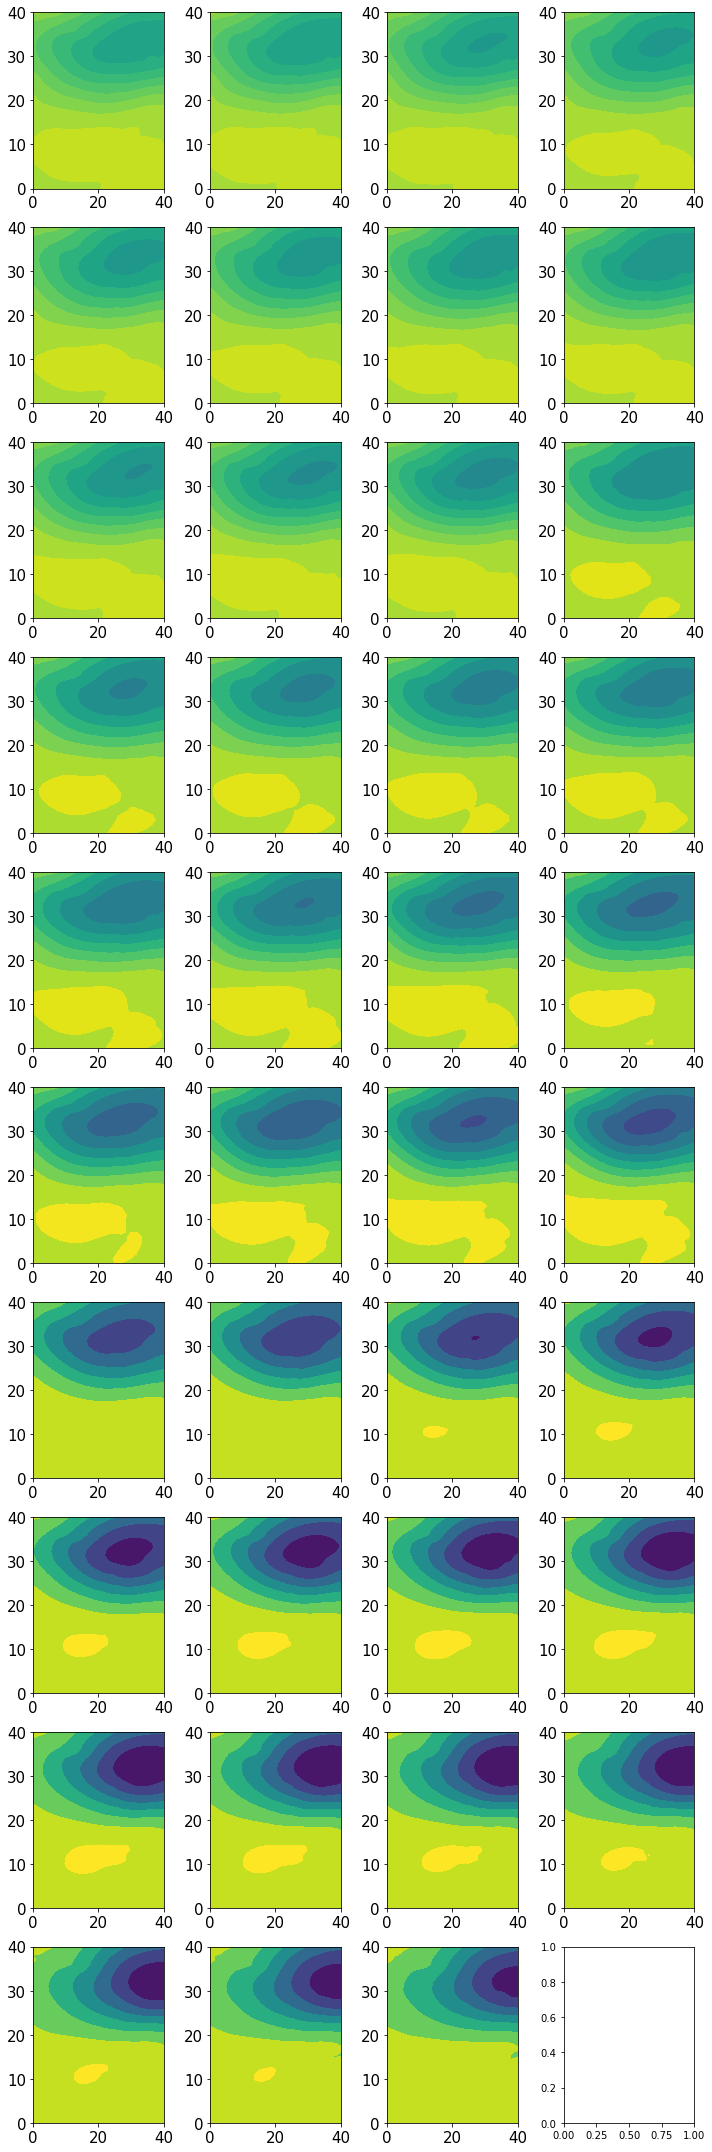

In [331]:
fig, _axs = plt.subplots(nrows=10, ncols=4,figsize=(10, 30))
fig.subplots_adjust(hspace=0.4)
axs = _axs.flatten()
norm1=cm.colors.Normalize(vmax=np.max(covariances), vmin=np.min(covariances))
for i in range (1,len(axs)):
    axs[i-1].contourf(np.roll(covariances[i],-11,axis=1),norm=norm1)
    axs[i-1].tick_params(labelsize='15')
fig.tight_layout()
plt.show()

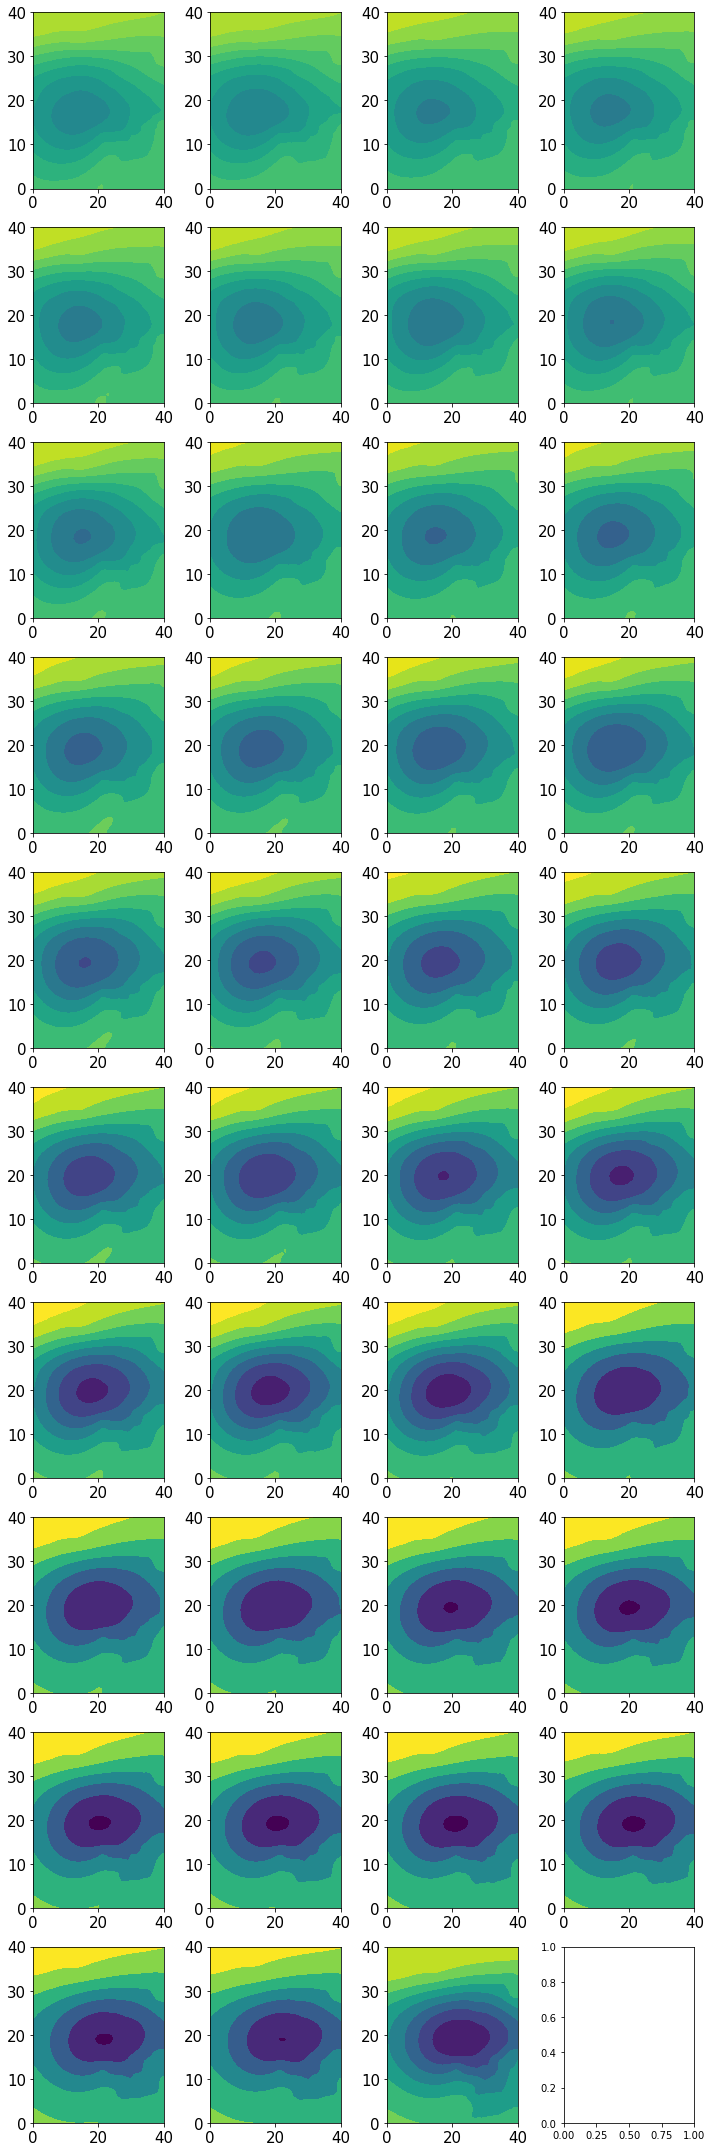

In [334]:
fig, _axs = plt.subplots(nrows=10, ncols=4,figsize=(10, 30))
fig.subplots_adjust(hspace=0.4)
axs = _axs.flatten()
norm1=cm.colors.Normalize(vmax=np.max(covariances2), vmin=np.min(covariances2))
for i in range (1,len(axs)):
    axs[i-1].contourf(np.roll(covariances2[i],-11,axis=1),norm=norm1)
    axs[i-1].tick_params(labelsize='15')
fig.tight_layout()
plt.show()

In [390]:
covariances2[:,1,11]

array([-40.2637907 , -34.64364951, -30.99139486, -34.65346497,
       -33.82296267, -28.15789453, -26.84318246, -30.54707241,
       -29.64011675, -22.94914446, -19.00412972, -22.25825187,
       -21.40909816, -15.25774491, -13.09072354, -16.04257058,
       -14.94472486,  -8.43076737,  -4.22484948,  -7.12043036,
        -6.68113144,  -0.82350961,   1.36430649,  -1.67034258,
        -0.76813055,   5.22298144,   8.81214174,   5.22253065,
         5.44280208,  11.05645396,  12.33449528,   9.30911774,
         9.91700935,  15.96132289,  18.87596871,  14.71328313,
        14.44576147,  19.98724489,  20.3102051 ,  16.30075328])

In [352]:
times=np.zeros(covariances2[1].shape)
for i in range(len(times)):
    for j in range(len(times[i])):
        times[i,j]=np.argmax(np.abs(covariances2[:,i,j])-len(covariances2[:,i,j]))

In [381]:
np.roll(times[1],-11)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., 39., 39., 39., 39., 39., 39.,
       39., 39., 39., 39., 39., 39., 39., 39., 39., 39., 39., 39., 39.,
       39., 39.])

[]

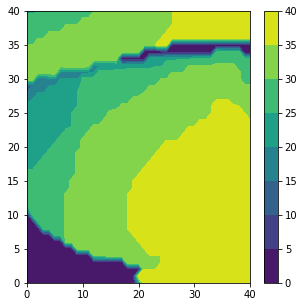

In [377]:
plt.figure(figsize=(5,5))
plt.contourf(np.roll(times,-11,axis=1))
plt.colorbar()
plt.plot()

In [357]:
times1=np.zeros(covariances[1].shape)
for i in range(len(times)):
    for j in range(len(times[i])):
        times1[i,j]=np.argmax(np.abs(covariances[:,i,j])-len(covariances[:,i,j]))

[]

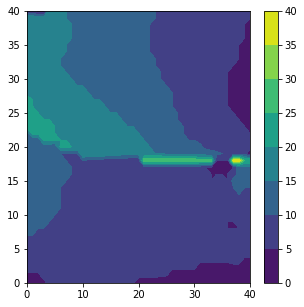

In [358]:
plt.figure(figsize=(5,5))
plt.contourf(np.roll(40-times1,-11,axis=1))
plt.colorbar()
plt.plot()

In [371]:
40-times[4,4]

1.0